# Preprocessing per classificazione multiclasse su `category`


In questo notebook viene effettuato il preprocessing utilizzando come variabile target:category.
- rimozione dei duplicati tramite df.drop_duplicates()
- siccome la colonna gdp_country presentava simboli come $, è stata pulita
- viene applicato il logaritmo per ridurre la skewness delle variabili finalWorth e gdp_country
- viene codificata selfMade (utilizzata per la classificazione binaria come target) in 0/1
- selezioone delle feature: dividiamo le colonne in numerical_cols e categorical_cols rispettivamente colonne numeriche e colonne categoriche
- i valori NaN vengono riempiti con la mediana
- rilevamento Outlier (metodo IQR): individua outlier usando la regola dell'intervallo interquantile e poi stampa gli outlier che ci sono per ogni colonna
- le colonne categoriche vengono trasformate con One-Hot-Encoding
- le categorie originali vengono raggruppate in macro-classi tramite un dizionario (category_map), successivamente le classi vengono poi codificate in numeri(LabelEncoder), e l'encoder viene salvato su disco
- viene creata la matrice X concatenando feature numeriche e categoriche
- vengono filtrati i record senza categoria target
- viene diviso il dataset in 70% per il training e 30% per il test
- Boxplot delle feature numeriche per vedere distribuzione e outlier

## Distribuzione del 'rank' per ciascuna categoria

Il grafico rappresenta la distribuzione stimata (KDE) del valore di rank per ciascuna delle 18 categorie presenti nel dataset.

### Osservazioni principali:
- Le curve mostrano l'**andamento della densità** del rank per categoria, evidenziando dove si concentrano i valori.
- In generale, tutte le categorie tendono a distribuirsi tra i 200 e i 2500 circa, ma con andamenti differenti.
- Alcune categorie (es. Manufacturing, Diversified Energy) mostrano un picco più netto, indicando una maggiore concentrazione di individui in una certa fascia di rank.
- Altre, come Technology o Logistics, hanno curve più piatte o con più picchi, suggerendo una distribuzione più varia.


### Utilità:
Questa visualizzazione è utile per capire come si distribuisce il successo (in termini di posizione/rank) all'interno dei diversi settori.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/processed/billionaires_clean.csv")

df = df[df["rank"].notna()]
df = df[df["rank"] >= 0]

plt.figure(figsize=(14, 7))

sns.kdeplot(
    data=df,
    x="rank",
    hue="category",
    fill=False,
    common_norm=False,
    linewidth=2,
    alpha=0.9,
    palette="tab20"  
)

plt.title("Distribuzione di 'rank' per ciascuna categoria", fontsize=16, fontweight="bold")
plt.xlabel("Rank", fontsize=14)
plt.ylabel("Densità stimata", fontsize=14)
plt.xlim(left=0)
plt.grid(True, linestyle="--", alpha=0.3)


handles, labels = plt.gca().get_legend_handles_labels()

if labels:  
    sorted_legend = sorted(zip(labels, handles), key=lambda x: x[0])
    labels, handles = zip(*sorted_legend)
    plt.legend(
        handles, labels,
        title="Categoria",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0.,
        fontsize="small",
        title_fontsize="medium"
    )


plt.tight_layout()


plt.savefig("../results/distribuzione_rank_per_categoria.png", dpi=300)

plt.show()

Adesso andiamo a vedere la distribuzioni delle categorie

Numero di istanze per classe:
category
Automotive                     71
Construction & Engineering     42
Diversified                   187
Energy                        100
Fashion & Retail              261
Finance & Investments         364
Food & Beverage               209
Gambling & Casinos             25
Healthcare                    200
Logistics                      39
Manufacturing                 319
Media & Entertainment          87
Metals & Mining                72
Real Estate                   191
Service                        53
Sports                         39
Technology                    313
Telecom                        30
Name: count, dtype: int64


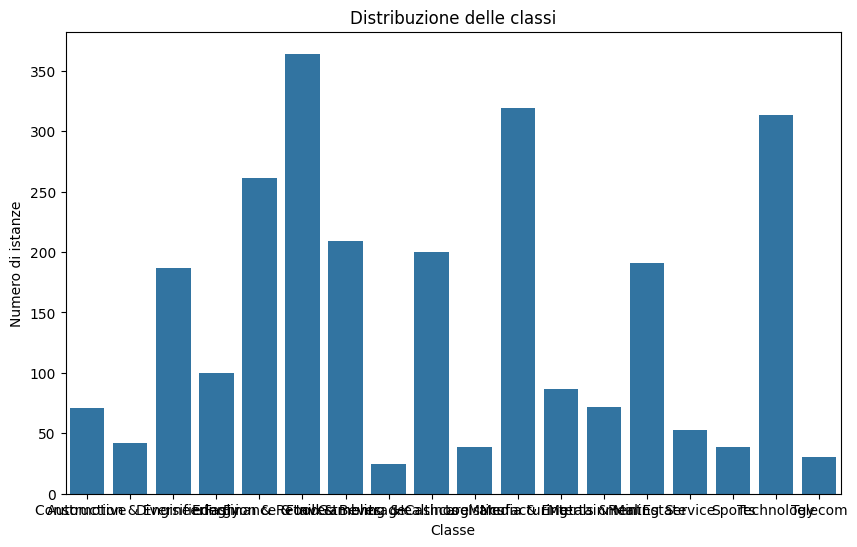

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/processed/billionaires_clean.csv")

class_counts = df['category'].value_counts().sort_index()

print("Numero di istanze per classe:")
print(class_counts)

plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel("Classe")
plt.ylabel("Numero di istanze")
plt.title("Distribuzione delle classi")
plt.show()



 Valori mancanti prima del trattamento:
selfMade_encoded                         0
log_finalWorth                           0
age                                     65
log_gdp_country                        164
cpi_country                            184
life_expectancy_country                182
gross_tertiary_education_enrollment    182
total_tax_rate_country                 182
population_country                     164
dtype: int64

 Numero di outlier per variabile:
selfMade_encoded_outlier                         0
log_finalWorth_outlier                          81
age_outlier                                     10
log_gdp_country_outlier                         30
cpi_country_outlier                            469
life_expectancy_country_outlier                182
gross_tertiary_education_enrollment_outlier      0
total_tax_rate_country_outlier                   4
population_country_outlier                       0
dtype: int64

 Dataset pronto per la classificazione su 'category

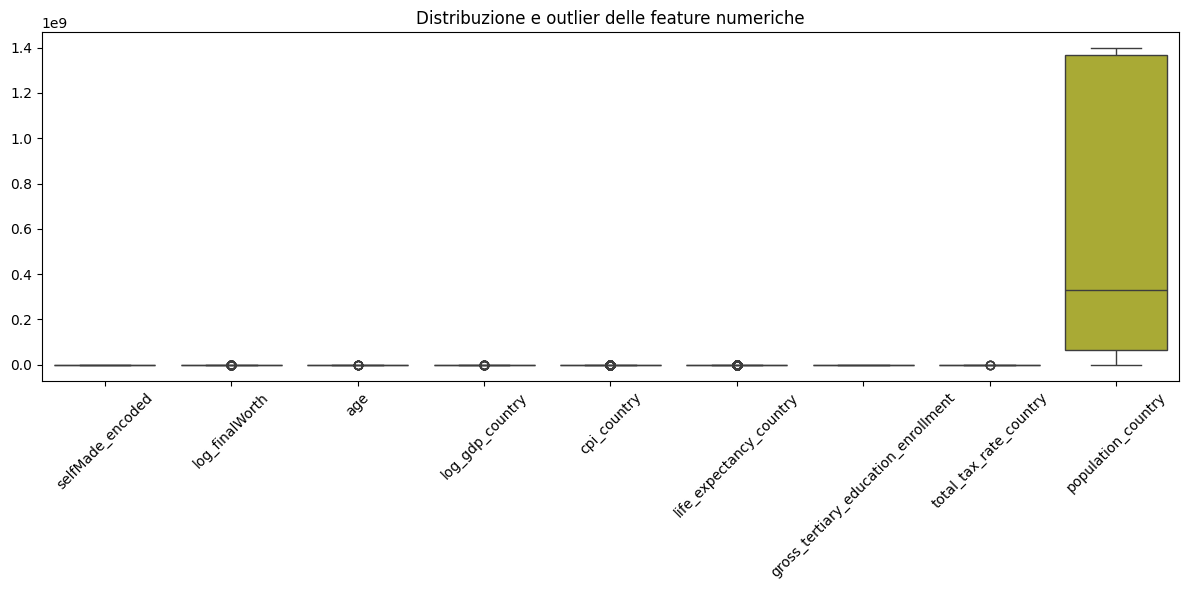

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

INPUT_PATH = "../data/raw/Billionaires Statistics Dataset.csv"
OUTPUT_DIR = "../data/splitted_category"
os.makedirs(OUTPUT_DIR, exist_ok=True)

df = pd.read_csv(INPUT_PATH)
df = df.drop_duplicates()

df['gdp_country'] = df['gdp_country'].astype(str).str.replace("$", "", regex=False)
df['gdp_country'] = df['gdp_country'].str.replace(",", "").str.strip()
df['gdp_country'] = pd.to_numeric(df['gdp_country'], errors='coerce')



df["log_finalWorth"] = np.log1p(df["finalWorth"])
df["log_gdp_country"] = np.log1p(df["gdp_country"])
df["selfMade_encoded"] = df["selfMade"].map({True: 1, False: 0})




numerical_cols = ['selfMade_encoded', 'log_finalWorth', 'age', 'log_gdp_country', 'cpi_country',
                  'life_expectancy_country', 'gross_tertiary_education_enrollment',
                  'total_tax_rate_country', 'population_country']

categorical_cols = ['country', 'source', 'gender', 'status']


for col in numerical_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)


outlier_mask = pd.DataFrame(index=df.index)
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_mask[col + '_outlier'] = ~df[col].between(lower, upper)



categorical_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)


category_map = {
    'Automotive': 'Industry',
    'Construction & Engineering': 'Industry',
    'Manufacturing': 'Industry',
    'Metals & Mining': 'Industry',
    'Logistics': 'Industry',
    'Finance & Investments': 'Finance & Real Estate',
    'Real Estate': 'Finance & Real Estate',
    'Food & Beverage': 'Consumer & Leisure',
    'Gambling & Casinos': 'Consumer & Leisure',
    'Fashion & Retail': 'Media & Culture',
    'Media & Entertainment': 'Media & Culture',
    'Service': 'Media & Culture',
    'Sports': 'Media & Culture',
    'Healthcare': 'Health & Tech',
    'Telecom': 'Health & Tech',
    'Technology': 'Health & Tech',
    'Energy': 'Energy',
    'Diversified': 'Diversified'
}

df["new_category"] = df["category"].map(category_map)

target = 'new_category'
y = df[target]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

joblib.dump(le, "../models/label_encoder_category.joblib")

df = df.drop(columns=["category", "new_category"])


X = pd.concat([df[numerical_cols], categorical_encoded], axis=1)

mask = y.notna()
X = X[mask]
y_encoded = y_encoded[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

X_train.to_csv(os.path.join(OUTPUT_DIR, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(OUTPUT_DIR, "X_test.csv"), index=False)
pd.Series(y_train, name="category_encoded").to_csv(os.path.join(OUTPUT_DIR, "y_train.csv"), index=False)
pd.Series(y_test, name="category_encoded").to_csv(os.path.join(OUTPUT_DIR, "y_test.csv"), index=False)

print("\n Dataset pronto per la classificazione su 'category'. Salvato in '../data/splitted_category/'")

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_cols])
plt.title("Distribuzione e outlier delle feature numeriche")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()






Al fine di vedere meglio i box plot viene temporaneamente rimossa la variabile population country e finalWorth.
Il grafico mostra la distribuzione delle variabili numeriche presenti nel dataset, con particolare attenzione alla rilevazione di outlier. 


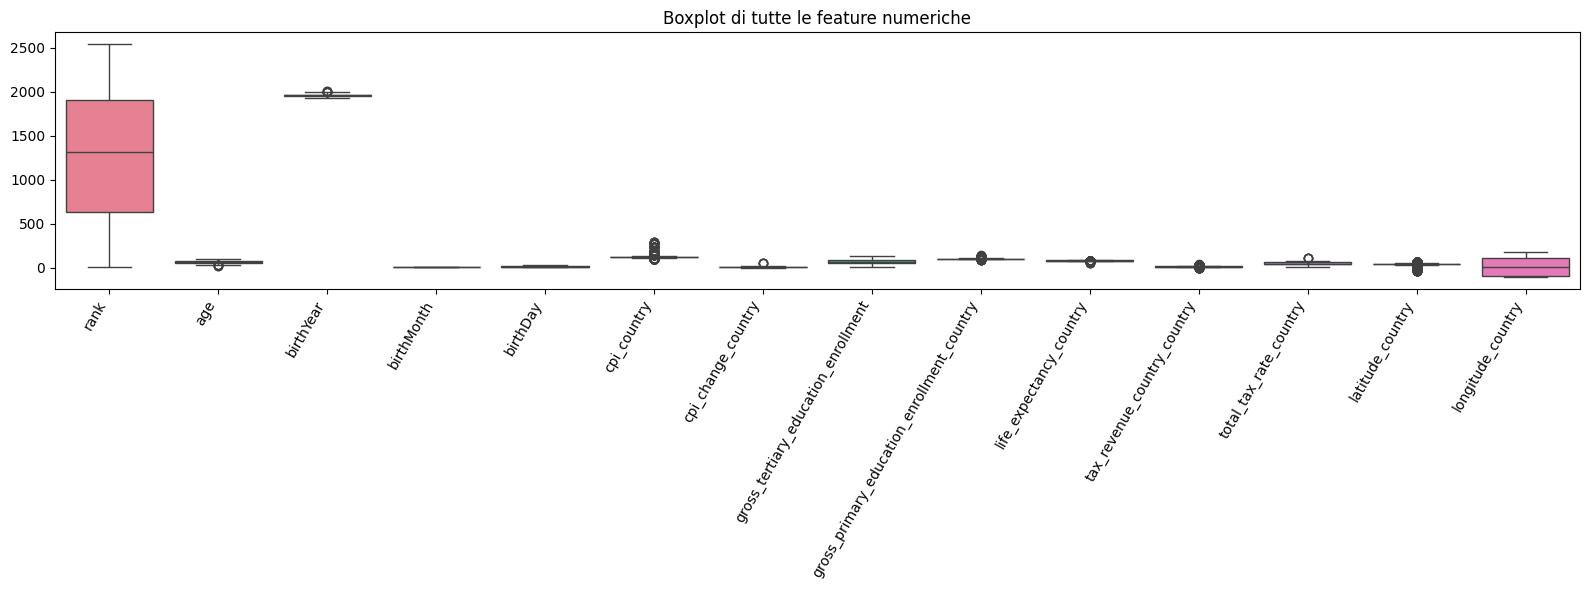

In [ ]:
cols_to_plot = df.drop(columns=["population_country", "finalWorth"]).select_dtypes(include='number').columns
plt.figure(figsize=(16, 6))
sns.boxplot(data=df[cols_to_plot])
plt.xticks(rotation=60, ha='right')
plt.title("Boxplot delle feature numeriche")
plt.tight_layout()
plt.show()

# Viene visualizzato la distribuzione delle categorie aggregate

0: Consumer & Leisure
1: Diversified
2: Energy
3: Finance & Real Estate
4: Health & Tech
5: Industry
6: Media & Culture
Numero di istanze per classe (dopo accorpamento):
0    166
1    131
2     70
3    396
4    382
5    389
6    314
Name: count, dtype: int64


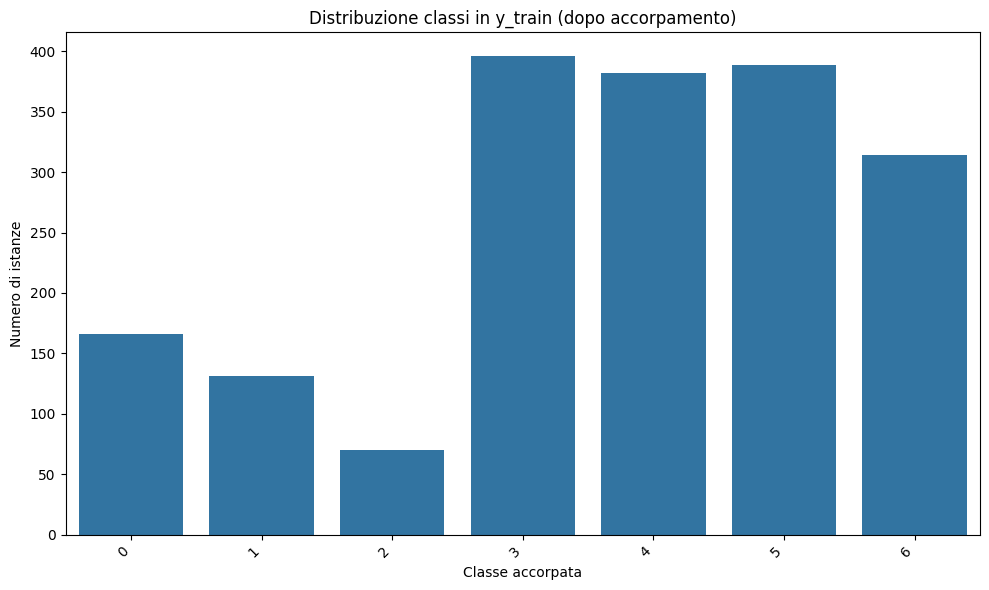

Numero di istanze per classe (dopo accorpamento):
0     71
1     56
2     30
3    169
4    164
5    167
6    135
Name: count, dtype: int64


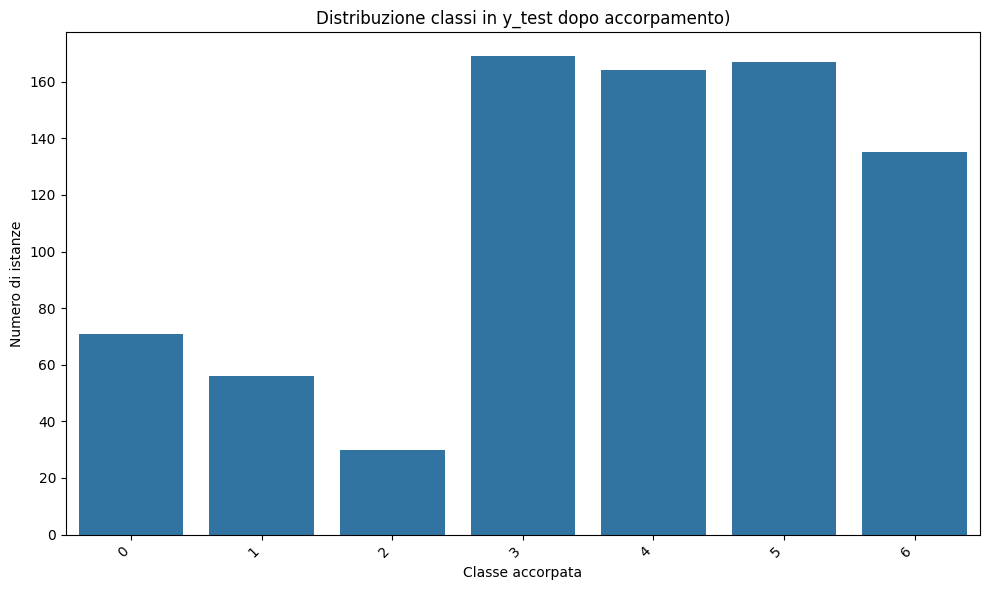

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
X_train = pd.read_csv("../data/splitted_category/X_train.csv")
X_test = pd.read_csv("../data/splitted_category/X_test.csv")
y_train = pd.read_csv("../data/splitted_category/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/splitted_category/y_test.csv").values.ravel()  
# Converte y_train in una Series per conteggio
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Conta e ordina
class_counts1 = y_train_series.value_counts().sort_index()
class_counts2 = y_test_series.value_counts().sort_index()

# Viene caricato il labelencoder salvato al fine di visualizzare le categorie associate
# a ciascun indice
le = joblib.load("../models/label_encoder_category.joblib")

for idx, label in enumerate(le.classes_):
    print(f"{idx}: {label}")

print("Numero di istanze per classe (dopo accorpamento):")
print(class_counts1)

# Barplot 1
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts1.index, y=class_counts1.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Classe accorpata")
plt.ylabel("Numero di istanze")
plt.title("Distribuzione classi in y_train (dopo accorpamento)")
plt.tight_layout()
plt.show()


print("Numero di istanze per classe (dopo accorpamento):")
print(class_counts2)

# Barplot 2
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts2.index, y=class_counts2.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Classe accorpata")
plt.ylabel("Numero di istanze")
plt.title("Distribuzione classi in y_test dopo accorpamento)")
plt.tight_layout()
plt.show()
